**Model Skeleton**

Click [here](https://docs.google.com/document/d/1v8xBxDOmItnDbMlbNnb4KsY-F7_jp1F9RJ-aIMr2KHA/edit?usp=sharing) for a detailed description of the purpose of every code chunk

**Make sure to run this script on Google Colab to ensure compatability with Drive mounting**

**0) Import Dependencies and Mount Drive**

In [1]:
# ─── Standard Library ───────────────────────────────────────────────────────
import os
import re
import glob
import time
import struct
import random
import shutil
from datetime import datetime
from collections import Counter, OrderedDict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

# ─── Data Handling ──────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ─── Visualization ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Machine Learning & PyTorch ─────────────────────────────────────────────
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
import torch.backends.cudnn as cudnn
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# ─── Computer Vision ────────────────────────────────────────────────────────
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import pad
from torchvision.utils import save_image
from PIL import Image, UnidentifiedImageError
import cv2
from skimage import io, color
import timm  # For accessing pretrained models beyond torchvision

# ─── Metrics & Evaluation ───────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

# ─── Progress Monitoring ────────────────────────────────────────────────────
from tqdm.auto import tqdm
import os, subprocess


import os
import shutil
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
from PIL import Image
import pandas as pd
import re
import time
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import struct
import numpy as np
from torch.nn.functional import pad
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from collections import Counter


# ─── Reproducibility ────────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
# 0. Variables from your unzipping script
# These should match what you used for unzipping
#zip_path = '/content/drive/MyDrive/Patches_Apr27.zip' # Source ZIP on Drive
#extract_dir = '/content/Patches_Apr27' # Local extraction directory

In [4]:
import os
from google.colab import drive
import shutil

# 1. Mount Google Drive (skip remount warning)
drive.mount('/content/drive')

# 2. Paths
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip'
extract_dir = '/content/Patches_Apr27'

# 3. Remove any previous partial extraction
if os.path.exists(extract_dir):
    print("🗑️ Removing old extract folder...")
    shutil.rmtree(extract_dir)

# 4. Re-unzip using shell unzip (handles large files better)
print("📦 Re-unzipping ZIP to /content...")
!unzip -q -o "$zip_path" -d "/content"
print("✅ Unzipping complete.")

# 5. Count image files
image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
image_files = []
for root, _, files in os.walk(extract_dir):
    for f in files:
        if os.path.splitext(f)[1].lower() in image_exts:
            image_files.append(os.path.join(root, f))

print(f"📸 Total image files after fresh unzip: {len(image_files)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Re-unzipping ZIP to /content...
✅ Unzipping complete.
📸 Total image files after fresh unzip: 73301


**1. Configuration**

*Contains everything we can change about the model besides the model itself. The only other part of the code you should need to modify is in the section "Define Your Model and Train"*

- Paths to our data (**update these paths with the paths from your own drive**)
    - drive_image_folder (this is the drive folder with all images)
    - label_csv (this is the path with true labels "case_grade_match.csv")
    - meta_csv_full_scan (this is the path where the metadata is saved)

- Data to train on (**update these params with the cases you want to train on**)
    - train_cases
    - test_cases
    - validation_cases

- Filtering Parameters (**update these params with the stains and sizes you want to train on**)
    - target_stain
    - min_image_size
    - max_image_size
- Hyperparameters
    - lr (learning rate)
    - num_epochs (number of epochs)
    - batch_size

- Other Parameters
    - force_rebuild_metadata_full
        - This will rebuild the metadata each time
        - **Only set to false if you have not changed any other parameters** (meaning that your filtering params and data to train on have not changed)

    - Device
        - Controls what hardware (GPU vs. CPU etc) we use (defualt GPU)
    - num_workers
        - Param for the data loader. If num_workers > 0, we load + preprocess data in parallel with model training.
        - currently not in use bc data loading is fast




In [5]:
#Create train, test, and val lists
#train_test_val_df = pd.read_csv("/content/drive/MyDrive/ML model comparison - Train-test split.csv")
#train_list = train_test_val_df[train_test_val_df.Data == "Train"].Case.to_list()
#test_list = train_test_val_df[train_test_val_df.Data == "Test"].Case.to_list()
#val_list = train_test_val_df[train_test_val_df.Data == "Validate"].Case.to_list()

In [6]:
# ─── 1) CONFIG (Updated for Full Scan & Local Paths) ──────────────────────────────────
CONFIG = {
    #MODIFIED: Changed from 'drive_image_folder' and updated path
    'local_image_folder': extract_dir,  # read directly from /content/Patches_Apr27
    'label_csv': "/content/drive/MyDrive/case_grade_match.csv", # Assuming labels still on Drive
    'meta_csv_full_scan': "/content/metadata_full_scan_local_paths.csv",  # Explicitly local
    'batch_size': 32,
    'num_workers': 4, # Adjusted for potentially faster local I/O
    'lr': 1e-3,
    'num_epochs': 20,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'train_cases': [2,4,22,24,26,28,30,34,36,53,79,82,86,96,1,5,9,12,17,18,32,40,42,44,48,49,51,54,55,58,66,67,68,69,70,72,80,87,88,91,92,95,99,100,104,59,16],
    'test_cases': [23,27,45,46,78,85,14,15,19,38,50,65,83,84,97],
    'validation_cases':[21,25,43,56,93,94,3,7,11,47,57,64,73,75,98],
    'force_rebuild_metadata_full': True, # Set to True for the first run with new paths
    'min_image_size': 50,
    'max_image_size': 100000,
    'target_stain': 'h&e'
}

# Combine all cases from train/val/test for the initial full metadata scan
all_cases_for_scan = set(CONFIG['train_cases'] + CONFIG['test_cases'] + CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(all_cases_for_scan)}")
print(f"Target stain for this run: {CONFIG['target_stain']}")
print(f"🖼️ Image data will be read from: {CONFIG['local_image_folder']}") # Verify local path
if CONFIG['force_rebuild_metadata_full']:
    print("❗ Metadata will be rebuilt.")
torch.backends.cudnn.benchmark = True


Cases included in initial full metadata scan: 77
Target stain for this run: h&e
🖼️ Image data will be read from: /content/Patches_Apr27
❗ Metadata will be rebuilt.


**Note** – the ```n_buckets``` input for our bucketing logic is not included in the CONFIG. You'll have to manually change it the code chunk where we create the boundaries and data loaders (see below in section 6). The default is just to keep ```n_buckets``` = number of batches.

**2) Build Metadata**

Uses 3 code chunks

1) Helper functions: help optimize build_metadata function

2) Build metadata function: creates metadata

3) Calling build metadata

In [7]:
# ─── 1) HELPERS ──────────────────────────────────────────────────────────────
# Regex for filenames like "case_001_match_…png" or "case_12_unmatched_…png"
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)

def fast_scan(root, max_retries=3, backoff=1.5):
    """
    Efficiently and safely scans a directory tree for .png files.
    Automatically retries failed directory reads (useful for Google Drive in Colab).
    Args:
        root (str): Root directory to scan.
        max_retries (int): Max retries per failed directory.
        backoff (float): Base multiplier for exponential delay between retries.
    """
    def scan_dir(path, retries=0):
        try:
            # Check if path exists before scanning
            if not os.path.exists(path):
                print(f"⚠️ Directory not found: {path}. Skipping scan for this path.")
                return [] # Return empty iterator if path doesn't exist

            for entry in os.scandir(path):
                if entry.is_file() and entry.name.lower().endswith('.png'):
                    yield entry.path
                elif entry.is_dir():
                    yield from scan_dir(entry.path) # Recursive call
        except OSError as e:
            if retries < max_retries:
                wait = backoff ** retries
                print(f"⚠️  I/O error on {path} (attempt {retries+1}/{max_retries}). Retrying in {wait:.1f}s...")
                time.sleep(wait)
                yield from scan_dir(path, retries + 1)
            else:
                print(f"❌ Skipping {path} after {max_retries} failed attempts due to OSError: {e}")
        except FileNotFoundError: # Explicitly handle FileNotFoundError during scandir
             print(f"⚠️ Directory not found during scandir: {path}. Skipping.")
             return []
    return scan_dir(root)

In [8]:
# ─── 2) OPTIMIZED METADATA BUILDER ───────────────────────────────────────────
def build_metadata(image_folder, all_cases, meta_csv, stain,
                   force_rebuild=False, min_width=0, max_width=float('inf'),
                   num_workers=4):
    """
    Builds or loads a filtered metadata DataFrame:
      - only cases in `all_cases`
      - only files whose paths contain `stain`
      - only images with width/height in (min_width,max_width) or unknown dims (-1)
    """
    # Try loading existing CSV
    if os.path.exists(meta_csv) and not force_rebuild:
        try:
            df = pd.read_csv(meta_csv)
            required = {'path','case_number','stain','width','height'}
            if required.issubset(df.columns):
                # apply filters
                df = df[df.case_number.isin(all_cases)]
                # Ensure width/height are numeric for filtering, coerce errors to NaN then fill with -1
                df['width'] = pd.to_numeric(df['width'], errors='coerce').fillna(-1).astype(int)
                df['height'] = pd.to_numeric(df['height'], errors='coerce').fillna(-1).astype(int)

                df = df[((df.width  >= min_width) & (df.width  <= max_width)) | (df.width  == -1)] # inclusive min/max
                df = df[df.stain.str.lower() == stain.lower()]
                print(f"Loaded & filtered {len(df)} rows from {meta_csv}")
                if not df.empty:
                     # CRITICAL: Verify that paths are what you expect (local paths)
                    print(f"Example path from loaded metadata: {df['path'].iloc[0]}")
                return df
        except Exception as e:
            print(f"❗ Error loading or filtering {meta_csv}: {e}; rebuilding…")

    # Full rescan
    print(f"🔍 Scanning {image_folder} for stain='{stain}'…")
    if not os.path.exists(image_folder):
        print(f"❌ Error: Image folder for scanning does not exist: {image_folder}")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])

    files = list(fast_scan(image_folder))
    if not files:
        print(f"⚠️  No PNG files found in {image_folder} or its subdirectories.")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])
    print(f"Found {len(files)} PNG files during scan.")

    def proc(p):
        # p will be a full local path like /content/Patches_Apr27/case_001_match_xyz.png
        m = case_pat.search(os.path.basename(p))
        if not m:
            return None
        cid = int(m.group(1))

        if cid not in all_cases:
            return None
        if stain.lower() not in p.lower(): # Simple substring check for stain in path
            return None

        w, h = -1, -1
        try:
            with open(p,'rb') as f:
                hdr = f.read(24)
            if hdr.startswith(b'\x89PNG\r\n\x1a\n') and hdr[12:16] == b'IHDR':
                w = struct.unpack('>I',hdr[16:20])[0]
                h = struct.unpack('>I',hdr[20:24])[0]
            else: # Fallback if not standard PNG header or IHDR not where expected
                with Image.open(p) as img:
                    w, h = img.size
        except Exception as e:
            # print(f"Warning: Could not get dimensions for {p}: {e}")
            pass # Keep w,h as -1

        # size filter (inclusive)
        if w != -1 and not (min_width <= w <= max_width and min_width <= h <= max_width):
            return None

        return {
            'path': p, # This path is now a local path
            'case_number': cid,
            'stain': stain.lower(), # Store the target stain
            'width': w,
            'height': h
        }

    with ThreadPoolExecutor(max_workers=num_workers) as exe:
        rows = list(tqdm(exe.map(proc, files), total=len(files), desc="Processing files"))

    df = pd.DataFrame([r for r in rows if r])
    if df.empty:
        print(f"⚠️  No metadata built for stain='{stain}' after filtering. Check scan and filters.")
        return df

    df.to_csv(meta_csv, index=False)
    print(f"✅ Built & saved {len(df)} rows to {meta_csv}")
    if not df.empty:
        print(f"Example path from NEWLY BUILT metadata: {df['path'].iloc[0]}")
    return df

In [9]:
# create metadata
full_meta_df = build_metadata(
    image_folder=CONFIG['local_image_folder'], # MODIFIED: Use the local image folder
    all_cases=all_cases_for_scan,
    meta_csv=CONFIG['meta_csv_full_scan'],
    stain=CONFIG['target_stain'],
    force_rebuild=CONFIG['force_rebuild_metadata_full'],
    min_width=CONFIG['min_image_size'],
    max_width=CONFIG['max_image_size'],
    num_workers=CONFIG['num_workers']
)

# Ensure full_meta_df is not empty before proceeding
if full_meta_df.empty:
    print("❌ Metadata DataFrame is empty. Cannot proceed. Please check previous steps, especially the image path and scan.")
    # exit() # Or handle appropriately

🔍 Scanning /content/Patches_Apr27 for stain='h&e'…
Found 73301 PNG files during scan.


Processing files: 100%|██████████| 73301/73301 [00:06<00:00, 10657.03it/s]


✅ Built & saved 30255 rows to /content/metadata_full_scan_local_paths.csv
Example path from NEWLY BUILT metadata: /content/Patches_Apr27/case_24_unmatched_2_h&e_patch38.png


**Note**: You might get an I/O error upon running the create metadata code chunk. This is because of occasional timeout errors with connecting to Google Drive given how large our patches folder is. Rerun the code chunks until now if you face this error, and it should work after a few retries (this is assuming you haven't messed with the CONFIG settings or metadata file). You may also want to try restarting the runtime and re-running all the code chunks.

**3. Load Labels**
- This loads in the class labels and creates a labels map

In [10]:
# ─── 3) LOAD LABELS_MAP ─────────────────────────────────────────────────────
if not os.path.exists(CONFIG['label_csv']):
    raise FileNotFoundError(f"Labels CSV missing: {CONFIG['label_csv']}")
labels_df = (
    pd.read_csv(CONFIG['label_csv'])
      .drop(index=64, errors='ignore')
      .reset_index(drop=True)
)
labels_map = {
    int(r.Case): (0 if r.Class == 1 else 1)
    for _, r in labels_df.iterrows()
}
print(f"🗺️  Created labels_map for {len(labels_map)} cases")


🗺️  Created labels_map for 105 cases


**4. Define Transforms**

- **Important** The mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] values are specific to models that are pretrained on ImageNet. If your model was pretrained on a different dataset, your mean and std values should be calculated based on the properties of that dataset
- Adjust the transformations as per requirements of your specific model

In [11]:
# ─── TRANSFORMS (Adaptive Pooling Approach) ───────────────────────────
# These transforms are applied to individual images by the Dataset's __getitem__.

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), # Example augmentation
    transforms.RandomRotation(15), # Example augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), # Example augmentation
    transforms.ToTensor(), # Converts PIL Image to Tensor and scales [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet standard deviation
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # Converts PIL Image to Tensor and scales [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet standard deviation
])

**5) Create Dataset Objects for Train, Test, and Validation**

1) Define dataset class

2) Create datasets for train, test, and val

In [12]:
# --- Corrected PatchDataset Class ---
class PatchDataset(Dataset):
    def __init__(self, meta_df, labels_map, transform=None):
        """
        Args:
            meta_df (pd.DataFrame): Metadata DataFrame containing columns: path, case_number, stain, width, height
            labels_map (dict): Mapping of case number to class label
            transform (callable): Optional transform to apply to each image
        """
        self.meta = meta_df

        # Build list of (path, label) from filtered metadata
        # THIS LINE MUST EXECUTE BEFORE you try to access self.samples
        self.samples = [
            (row.path, labels_map[int(row.case_number)])
            for row in self.meta.itertuples()
            if int(row.case_number) in labels_map
        ]
        self.transform = transform

        # NOW it's safe to print the length of self.samples
        print(f"DEBUG: Dataset initialized with {len(self.samples)} total samples.")

    def __len__(self) -> int:
        return len(self.samples)
    def __getitem__(self, idx: int):
            # The IndexError traceback means this 'idx' is out of range for 'self.samples'
            # The primary fix for that is ensuring __len__ and __init__ are correct
            # This print will help verify if it's still being called with bad indices
            # print(f"DEBUG: __getitem__ called with idx = {idx}. len(self.samples) = {len(self.samples)}")

            # Ensure idx is within bounds. If this check triggers, the problem is in __len__ or DataLoader
            if not (0 <= idx < len(self.samples)):
                raise IndexError(f"__getitem__ called with invalid index {idx}. Valid range is [0, {len(self.samples)-1}]")

            path, label = self.samples[idx] # This is the line that errors

            try:
                img = Image.open(path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                cid = int(case_pat.search(os.path.basename(path)).group(1))
                return img, label, cid
            except Exception as e:
                # --- CRITICAL FIX HERE ---
                # DO NOT return None. Instead, log the error and re-raise it.
                # This will force the DataLoader to stop at the first genuinely problematic image file.
                print(f"ERROR: Failed to load or process image at index {idx} from path: '{path}'. Error: {e}")
                raise # Re-raise the exception to stop execution and debug the root cause

In [13]:
# --- Splitting metadata and creating datasets ---
# (Small modifications to handle potentially empty full_meta_df)
if not full_meta_df.empty:
    train_meta = full_meta_df[full_meta_df['case_number'].isin(CONFIG['train_cases'])].reset_index(drop=True)
    val_meta   = full_meta_df[full_meta_df['case_number'].isin(CONFIG['validation_cases'])].reset_index(drop=True)
    test_meta  = full_meta_df[full_meta_df['case_number'].isin(CONFIG['test_cases'])].reset_index(drop=True)

    if train_meta.empty or val_meta.empty or test_meta.empty:
        print("⚠️ One or more metadata splits (train/val/test) are empty. Check case lists and filtering.")

    train_dataset = PatchDataset(train_meta, labels_map, transform=train_transform)
    val_dataset   = PatchDataset(val_meta, labels_map, transform=eval_transform)
    test_dataset  = PatchDataset(test_meta, labels_map, transform=eval_transform)

    print(f"✅ Train patches: {len(train_dataset)}")
    print(f"✅ Val patches: {len(val_dataset)}") # Fixed typo from Test to Val
    print(f"✅ Test patches: {len(test_dataset)}")
else:
    print("❌ Skipping dataset creation due to empty full_meta_df.")
    # Initialize empty datasets or handle error
    train_dataset, val_dataset, test_dataset = None, None, None

DEBUG: Dataset initialized with 15667 total samples.
DEBUG: Dataset initialized with 5991 total samples.
DEBUG: Dataset initialized with 7606 total samples.
✅ Train patches: 15667
✅ Val patches: 5991
✅ Test patches: 7606


**6) Data Loader and Helper Functions**


There are 3 code chunks for 3 different helper functions:
- BucketSampler: function behind our bucketing logic. It will group indices of similar-sized images together
- make_boundaries_for_buckets: will calculate and define the actual size boundaries for our batches
- collate_fn_pad: collate functions are used by the DataLoader object to group individual samples into a batch. Our custom function also performs the padding operation within each batch

**Bucketing logic**: Because we have to pad images up to the size of the largest image within each batch, we want to make sure that images within the same batch are of similar sizes. To do this, we will first calculate the total_number_of_batches that will be used per epoch (total images/batch size). Then we will separate the images by width into total_number_of_batches number of bins (e.g. if total_number_of_batches = 40, then there will be 40 bins). Then each of these bins will be a batch and sent separately to be trained on — thus images within the same batch are of very similar sizes and the amount of padding needed is very negligible).

In [14]:

# ─── HELPER: BUCKET BATCH SAMPLER ─────────────────────────────────────
# This Sampler is responsible for the "bucketing" logic.
# It groups indices of similar-sized images together.
class BucketBatchSampler(Sampler):
    """
    Samples batches by grouping indices into buckets based on data source sizes.
    Batches are created from indices within the same bucket.
    """
    def __init__(self, data_source_sizes, batch_size, boundaries, shuffle=True):
        """
        Args:
            data_source_sizes (list): List of sizes (e.g., max dimension after resize) for each item.
            batch_size (int): The desired batch size.
            boundaries (list): A sorted list of size thresholds defining the buckets.
                               An item with size S falls into bucket i if boundaries[i-1] < S <= boundaries[i].
            shuffle (bool): Whether to shuffle indices within buckets and the order of batches.
        """
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Create buckets based on boundaries
        bucket_indices = {i: [] for i in range(len(boundaries) + 1)}
        for idx, size in enumerate(data_source_sizes):
            # Determine which bucket the size falls into
            bucket_num = sum(size > b for b in boundaries)
            bucket_indices[bucket_num].append(idx)

        self.batches = []
        # Create batches from indices within each bucket
        for bucket_num in sorted(bucket_indices.keys()):
            indices_in_bucket = bucket_indices[bucket_num]
            if self.shuffle:
                np.random.shuffle(indices_in_bucket)

            for i in range(0, len(indices_in_bucket), batch_size):
                batch = indices_in_bucket[i:i+batch_size]
                if len(batch) > 0:
                    self.batches.append(batch)

        if self.shuffle:
            np.random.shuffle(self.batches)

    def __iter__(self):
        return iter(self.batches)

    def __len__(self):
        return len(self.batches)

In [15]:
# ─── HELPER: MAKE BUCKET BOUNDARIES (Optimized for N Batches) ─────────
# This helper is used to calculate the boundaries for the buckets.
def make_boundaries_for_buckets(sizes, n_buckets):
    """
    Creates bucket boundaries such that the data is split into approximately
    n_buckets groups of equal size based on the sorted 'sizes'.
    Returns n_buckets - 1 boundaries.
    """
    #if not sizes or n_buckets <= 1:
    if sizes is None or len(sizes) == 0 or n_buckets <= 1:
        return []

    # Convert to pandas Series to use quantile/percentile efficiently
    sizes_series = pd.Series(sizes)
    total_items = len(sizes_series)
    boundaries = []

    # Calculate quantiles to define boundaries
    # We need n_buckets - 1 division points
    quantiles = [(i / n_buckets) for i in range(1, n_buckets)]

    # Calculate the boundary values using quantiles
    # Handle potential errors if quantile calculation fails (e.g., not enough unique sizes)
    try:
        bounds = sizes_series.quantile(quantiles).tolist()
    except Exception:
        # Fallback to simpler percentile calculation if quantile fails
        qs = [100 * i / n_buckets for i in range(1, n_buckets)]
        bounds = np.percentile(sizes, qs).tolist()


    # Ensure boundaries are unique, sorted, and integer
    return sorted(list(set(int(b) for b in bounds)))

In [16]:


import torch
import torchvision.transforms.functional as F_tv
import numpy as np # For potential other data processing, though not strictly needed here

def collate_fn_pad(batch):
    # Separate images, labels, and cids from the batch
    # batch is a list of (img_tensor, label, cid) tuples
    imgs = [item[0] for item in batch]
    lbls = [item[1] for item in batch]
    cids = [item[2] for item in batch]

    # --- Step 1: Determine the maximum height and width within the CURRENT BATCH ---
    max_h_batch = 0
    max_w_batch = 0

    # Iterate through all images in the current batch to find max dimensions
    for img_tensor in imgs:
        # img_tensor.shape is (C, H, W)
        h, w = img_tensor.shape[1], img_tensor.shape[2]
        if h > max_h_batch:
            max_h_batch = h
        if w > max_w_batch:
            max_w_batch = w

    # --- Step 2: Pad each image in the current batch to these determined max dimensions ---
    padded_imgs = []
    for img_tensor in imgs:
        h, w = img_tensor.shape[1], img_tensor.shape[2]

        # Calculate padding amounts for this specific image to reach batch's max_h_batch and max_w_batch
        # We'll pad to the bottom and right for simplicity (left/top padding can be added for centering)
        pad_h_bottom = max_h_batch - h
        pad_w_right = max_w_batch - w

        # The pad function expects padding_left, padding_top, padding_right, padding_bottom
        # For padding to bottom-right, padding_left and padding_top are 0
        padding_amounts = (0, 0, pad_w_right, pad_h_bottom)

        # Apply padding
        padded_img = F_tv.pad(img_tensor, padding_amounts, fill=0) # fill=0 for black padding, or use mean/median
        padded_imgs.append(padded_img)

    # --- Step 3: Stack the padded images ---
    # Now, all tensors in padded_imgs should have identical dimensions (C, max_h_batch, max_w_batch)
    # torch.stack will work correctly.
    return torch.stack(padded_imgs), torch.tensor(lbls, dtype=torch.long), torch.tensor(cids)


In [17]:
def rand_bbox(size, lam):
    """
    Generates a random bounding box for CutMix.
    size: (N, C, H, W)
    lam: lambda value from Beta distribution
    """
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform coordinates
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, H)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_batch(images, labels, alpha=1.0):
    """
    Applies CutMix augmentation to a batch of images and labels.

    Args:
        images (Tensor): A batch of images (N, C, H, W).
        labels (Tensor): A batch of corresponding labels (N).
        alpha (float): Parameter for the Beta distribution.
                       A higher alpha leads to larger cutouts. Default is 1.0.

    Returns:
        tuple: (augmented_images, labels_a, labels_b, lambda_value)
               where labels_a and labels_b are the original and mixed labels,
               and lambda_value is the mixing coefficient for the loss.
    """
    if images.size(0) == 0: # Handle empty batches gracefully
        return images, labels, labels, 1.0

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(images.size(0)).to(images.device)

    # Assign labels for mixing
    labels_a = labels
    labels_b = labels[rand_index]

    # Generate bounding box coordinates
    bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)

    # Perform the CutMix operation on images
    images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]

    # Adjust lambda based on the actual area of the cutout
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1)) / (images.size()[-1] * images.size()[-2])

    return images, labels_a, labels_b, lam

In [18]:
# --- Create Samplers and DataLoaders ---
# (Added checks for empty datasets/metadata before creating samplers/loaders)

# Helper function to get filtered meta based on dataset's samples
def get_filtered_meta_for_sampler(original_meta_df, dataset_samples):
    # Get the paths that are actually in the dataset's samples
    dataset_paths = {path for path, _ in dataset_samples}
    # Filter the original meta_df to only include those paths
    filtered_meta = original_meta_df[original_meta_df['path'].isin(dataset_paths)].reset_index(drop=True)
    return filtered_meta

# --- TRAIN LOADER ---
if train_dataset and not train_meta.empty and len(train_dataset) > 0:
    # Filter train_meta to match the actual samples in train_dataset
    # This ensures len(filtered_train_meta) == len(train_dataset)
    filtered_train_meta = get_filtered_meta_for_sampler(train_meta, train_dataset.samples)

    train_widths = pd.to_numeric(filtered_train_meta['width'], errors='coerce').fillna(-1).astype(int)
    train_widths = train_widths[train_widths != -1] # Filter out unknown dimensions for bucket boundaries

    if not train_widths.empty:
        train_boundaries = make_boundaries_for_buckets(train_widths.tolist(), n_buckets=max(1, int(len(train_dataset)/CONFIG['batch_size'])))
        # Pass the widths from the FILTERED meta for the sampler
        train_batch_sampler = BucketBatchSampler(
            train_widths.tolist(), # Use the widths from the filtered meta
            batch_size=CONFIG['batch_size'],
            boundaries=train_boundaries
        )
        train_loader = DataLoader(
            train_dataset, pin_memory=True, num_workers=0,
            batch_sampler=train_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Train DataLoader created with {len(train_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create train_loader with buckets. Consider standard DataLoader.")
        train_loader = None # Or fallback to standard DataLoader
else:
    print("❌ Train dataset is empty or metadata missing. Skipping Train DataLoader.")
    train_loader = None

# --- VAL LOADER ---
if val_dataset and not val_meta.empty and len(val_dataset) > 0:
    filtered_val_meta = get_filtered_meta_for_sampler(val_meta, val_dataset.samples)
    val_widths = pd.to_numeric(filtered_val_meta['width'], errors='coerce').fillna(-1).astype(int)
    val_widths = val_widths[val_widths != -1]
    if not val_widths.empty:
        val_boundaries = make_boundaries_for_buckets(val_widths.tolist(), n_buckets=max(1, int(len(val_dataset)/CONFIG['batch_size'])))
        val_batch_sampler = BucketBatchSampler(
            val_widths.tolist(),
            batch_size=CONFIG['batch_size'],
            boundaries=val_boundaries
        )
        val_loader = DataLoader(
            val_dataset, pin_memory=True, num_workers=0,
            batch_sampler=val_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Validation DataLoader created with {len(val_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create val_loader with buckets.")
        val_loader = None
else:
    print("❌ Validation dataset is empty or metadata missing. Skipping Val DataLoader.")
    val_loader = None

# --- TEST LOADER ---
if test_dataset and not test_meta.empty and len(test_dataset) > 0:
    filtered_test_meta = get_filtered_meta_for_sampler(test_meta, test_dataset.samples)
    test_widths = pd.to_numeric(filtered_test_meta['width'], errors='coerce').fillna(-1).astype(int)
    test_widths = test_widths[test_widths != -1]
    if not test_widths.empty:
        test_boundaries = make_boundaries_for_buckets(test_widths.tolist(), n_buckets=max(1, int(len(test_dataset)/CONFIG['batch_size'])))
        test_batch_sampler = BucketBatchSampler(
            test_widths.tolist(), # Use the widths from the filtered meta
            batch_size=CONFIG['batch_size'],
            boundaries=test_boundaries
        )
        test_loader = DataLoader(
            test_dataset, pin_memory=True, num_workers=0,
            batch_sampler=test_batch_sampler, collate_fn=collate_fn_pad
        )
        print(f"✅ Test DataLoader created with {len(test_loader)} batches.")
    else:
        print("⚠️ Not enough valid width data to create test_loader with buckets.")
        test_loader = None
else:
    print("❌ Test dataset is empty or metadata missing. Skipping Test DataLoader.")
    test_loader = None

✅ Train DataLoader created with 604 batches.
✅ Validation DataLoader created with 266 batches.
✅ Test DataLoader created with 320 batches.


**Note** - be careful about the n_buckets input if you are using non-adaptive pooling layers in your model. The n_buckets parameter directly influences sizes of images being fed into the network, since the amount of padding varies based on distribution of image sizes in each bucket (and hence the resultant batches). If your model architecture has pooling layers with fixed kernel sizes, such as MaxPooling, you will have to be careful about what image sizes are fed into the network. This is not a problem with Adaptive Pooling since, as the name suggests, this layer adapts features such as kernel size in accordance to the desired output size.

**7) Data Visualization and Summary Statistics**

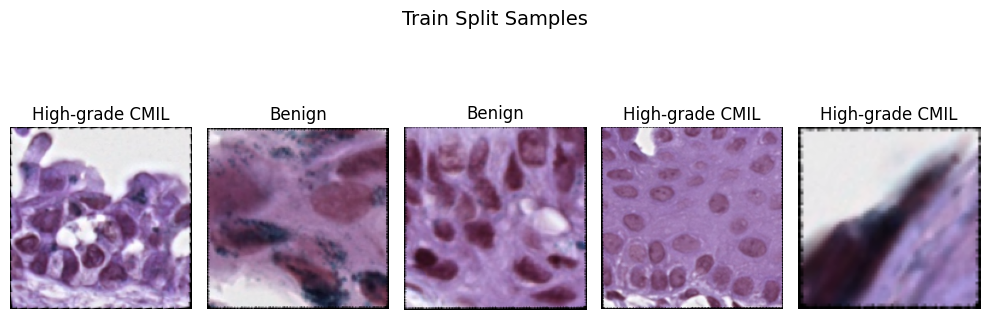


Train Set: Total Patches = 15667
  Benign (0):      8783
  High-grade (1):  6884

Validation Set: Total Patches = 5991
  Benign (0):      1980
  High-grade (1):  4011

Test Set: Total Patches = 7606
  Benign (0):      1567
  High-grade (1):  6039


In [19]:
def visualize_random_samples(meta_df, title="Samples", n_samples=5, max_candidates=20, n_threads=5):
    """
    Efficiently sample & plot `n_samples` images by:
      - Sampling up to `max_candidates` rows
      - Loading in parallel (ThreadPoolExecutor of size `n_threads`)
      - Skipping unreadable files
    """
    # 1) pick up to max_candidates random rows
    sample_paths = meta_df.sample(
        n=min(max_candidates, len(meta_df)),
        random_state=42
    ).path.tolist()

    # 2) helper to try to open one image
    def try_load(path):
        try:
            img = Image.open(path).convert('RGB')
            arr = np.array(img) / 255.0
            return path, arr
        except Exception:
            return None

    # 3) load in parallel, stop once we have n_samples
    loaded = []
    with ThreadPoolExecutor(max_workers=n_threads) as exe:
        futures = { exe.submit(try_load, p): p for p in sample_paths }
        for fut in as_completed(futures):
            res = fut.result()
            if res:
                loaded.append(res)
            if len(loaded) >= n_samples:
                break

    if not loaded:
        print("⚠️  Could not load any sample images.")
        return

    # 4) plot however many we got (up to n_samples)
    n = len(loaded)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=n)
    fig.suptitle(title, fontsize=14)
    for ax, (path, arr) in zip(axes, loaded):
        ax.imshow(arr)
        cid = int(case_pat.search(os.path.basename(path)).group(1))
        cls = "Benign" if labels_map[cid] == 0 else "High-grade CMIL"
        ax.set_title(cls)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Usage – should now be under 15 seconds:
visualize_random_samples(train_meta, title="Train Split Samples")

# ─── Step 10: Fast class-distribution counts ──────────────────────────────────
def print_meta_stats(name, meta_df):
    # count using metadata case_number → labels_map
    lbls = [ labels_map[cid] for cid in meta_df.case_number if cid in labels_map ]
    cnt = Counter(lbls)
    total = len(lbls)
    print(f"\n{name} Set: Total Patches = {total}")
    print(f"  Benign (0):      {cnt.get(0,0)}")
    print(f"  High-grade (1):  {cnt.get(1,0)}")

print_meta_stats("Train",      train_meta)
print_meta_stats("Validation", val_meta)
print_meta_stats("Test",       test_meta)


**8) Model Definition and Training**

**Define Generalized Model Traininng Function**

In [20]:
import os
import torch
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import subprocess  # for querying nvidia-smi

# Helper: move tensors or lists of tensors to device
def move_batch_to_device(images, labels, device):
    if isinstance(images, (list, tuple)):
        images = torch.stack([img.to(device, non_blocking=True) for img in images])
    else:
        images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    return images, labels

# Core training function with AMP + GPU Utilization Check, now skipping empty batches
def train_model(
        model,
        optimizer,
        criterion,
        train_loader,
        val_loader,
        epochs=3,
        scheduler=None,
        resume_from=None,
        device=None
    ):
    """
    Trains `model` using AMP (automatic mixed precision), saves checkpoints,
    and prints GPU utilization stats each epoch to verify A100 usage.
    Now also skips any empty batch (i.e. collate_fn_pad returned []).
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    torch.backends.cudnn.benchmark = True
    model.to(device)

    # Use the new GradScaler signature to avoid FutureWarning
    scaler = GradScaler()

    model_dir = "/content/drive/MyDrive/your_model_checkpoints" # Choose a meaningful folder name
    os.makedirs(model_dir, exist_ok=True)

    best_acc = 0.0
    start_epoch = 0

    if resume_from is not None and os.path.exists(resume_from):
        checkpoint = torch.load(resume_from, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint.get('val_accuracy', 0.0)
        print(f"🔁 Resumed from checkpoint at epoch {start_epoch} with accuracy {best_acc:.4f}")

    train_losses = []
    val_losses = []
    val_accuracies = []

    for e in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0

        train_bar = tqdm(train_loader, desc=f"Epoch {e+1}/{epochs}", leave=True)
        for batch in train_bar:
            if not batch:
                # skip empty batch
                continue

            images, labels, _ = batch  # `_` = case_ids (ignored)
            images, labels = move_batch_to_device(images, labels, device)

            if model.training: # Apply CutMix only during training
                images, labels_a, labels_b, lam = cutmix_batch(images, labels, alpha=1.0) # alpha is a hyperparameter to tune
            else: # For validation, set default values to avoid errors
                labels_a = labels
                labels_b = labels
                lam = 1.0

            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b) # The correct Cutmix loss calculation
                #loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss / (train_bar.n + 1))

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        if scheduler is not None:
            scheduler.step()

        # Print GPU stats after training phase
        if torch.cuda.is_available():
            try:
                gpu_stats = subprocess.check_output(
                    [
                        "nvidia-smi",
                        "--query-gpu=utilization.gpu,utilization.memory,memory.used,memory.total",
                        "--format=csv,nounits,noheader"
                    ],
                    stderr=subprocess.DEVNULL
                ).decode("utf-8").strip()
                gpu_util, mem_util, mem_used, mem_total = [x.strip() for x in gpu_stats.split(',')]
                print(f"🔍 [GPU Util] GPU: {gpu_util}% | Mem: {mem_util}% "
                      f"({mem_used}/{mem_total} MiB)")
            except Exception:
                print(f"🔍 [CUDA] Alloc: {torch.cuda.memory_allocated(device)/1024**2:.1f} MiB | "
                      f"Cached: {torch.cuda.memory_reserved(device)/1024**2:.1f} MiB")

        # Validation
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                if not batch:
                    continue

                images, labels, _ = batch
                images, labels = move_batch_to_device(images, labels, device)

                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                validation_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = validation_loss / len(val_loader)
        val_accuracy = correct / total

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(
            f"Epoch: {e+1}/{epochs}.. "
            f"Train Loss: {epoch_train_loss:.4f}.. "
            f"Val Loss: {avg_val_loss:.4f}.. "
            f"Val Accuracy: {val_accuracy:.4f}"
        )

        # Save checkpoint for this epoch
        checkpoint_path = os.path.join(model_dir, f"h&e_weight_decay_cutmix_model_epoch_{e+1}.pth")
        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        }, checkpoint_path)

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_path = os.path.join(model_dir, "h&e_weight_decay_cutmix_best_model.pth")
            torch.save(model.state_dict(), best_path)
            print(f"✅ New best model saved at epoch {e+1} with accuracy {val_accuracy:.4f}")

    # Plot metrics
    epochs_range = list(range(1, epochs + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy During Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


**Define Your Model and Train**

You need to specify 5 things (Do not specify anything else - they are already specified in the config)

1) Define your model object
```
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT) # Use updated weights API
```
2) Unfreeze any layers that you want
```
for p in model.parameters(): p.requires_grad=False
```

3) Replace the classifier head if you want and modify feature extractor to include AdaptivePooling



```
# Modify feature extractor to include AdaptiveAvgPool2d
model.features = nn.Sequential(*list(model.features), nn.AdaptiveAvgPool2d((6, 6)))
in_ftrs = 256 * 6 * 6

# Custom classifier
model.classifier = nn.Sequential(
    nn.Dropout(), nn.Linear(in_ftrs, 4096), nn.ReLU(inplace=True),
    nn.Dropout(), nn.Linear(4096, 4096), nn.ReLU(inplace=True),
    nn.Linear(4096, 2)
)
```



4) Define the optimizer and pass your trainable parameters

```
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["lr"]
)
```

5) Optional: Define your class weighting (for class imbalance) and update the criterion

```
from collections import Counter

def compute_class_weights(meta_df, labels_map):
    # Extract per‐patch labels
    lbls = [
        labels_map[int(cid)]
        for cid in meta_df.case_number
        if int(cid) in labels_map
    ]
    cnt = Counter(lbls)
    total = sum(cnt.values())
    # Inverse frequency: heavier weight for under-represented class
    w0 = total / cnt.get(0, 1)
    w1 = total / cnt.get(1, 1)
    return [w0, w1]

class_weights = compute_class_weights(train_meta, labels_map)

# Then your weighted‐loss setup becomes:
cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw_tensor)

```

If you are having trouble implementing this, plug-in these instructions and your model into ChatGPT.

In [21]:
import torch.nn as nn
from torch.nn import functional as F
from collections import Counter
import timm
# 1) Define your custom DeiT model
class DeiTClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super(DeiTClassifier, self).__init__()
        self.base_model = timm.create_model('deit_small_patch16_224', pretrained=pretrained)

        # Freeze all parameters in the base model initially
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace the classifier head for your specific number of classes (2 in this case)
        # DeiT models typically have a 'head' attribute for the classifier.
        in_features = self.base_model.head.in_features
        self.base_model.head = nn.Linear(in_features, num_classes)

        # Unfreeze the new classifier head
        for param in self.base_model.head.parameters():
            param.requires_grad = True

    def forward(self, x):
        # The DeiT model internally handles its pooling and feature extraction
        return self.base_model(x)

# Instantiate the model
model = DeiTClassifier(num_classes=2, pretrained=True)

# 2) Unfreezing layers is handled within the DeiTClassifier's __init__ method by default
# Only the new classifier head parameters are trainable.

# 3) Replace the classifier head (already done in DeiTClassifier's __init__)
# For DeiT, the model automatically handles the feature extraction and pooling before the head.
# No explicit AdaptiveAvgPool2d needs to be added to `model.features` directly
# as `timm` models are typically designed with their own internal pooling.

# Move model to device
device = CONFIG["device"]
model = model.to(device)

# 4) Define the optimizer and pass your trainable parameters
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=CONFIG["lr"],
    weight_decay=0.01
)

# 5) Optional: Define your class weighting (for class imbalance) and update the criterion
def compute_class_weights(meta_df, labels_map):
    # Extract per‐patch labels
    lbls = [
        labels_map[int(cid)]
        for cid in meta_df.case_number
        if int(cid) in labels_map
    ]
    cnt = Counter(lbls)
    total = sum(cnt.values())
    # Inverse frequency: heavier weight for under-represented class
    w0 = total / cnt.get(0, 1)
    w1 = total / cnt.get(1, 1)
    return [w0, w1]

class_weights = compute_class_weights(train_meta, labels_map)

# Then your weighted‐loss setup becomes:
cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw_tensor)

# --- Softmax fix for evaluate_model_case_level_svc ---
# This part is a modification to the existing function from your notebook.
# You'll need to ensure your `evaluate_model_case_level_svc` function uses
# the imported `softmax` or `F.softmax`.
# Example: `probs = softmax(outputs, dim=1)` or `probs = F.softmax(outputs, dim=1)`

# You would then run your training and evaluation steps:
# trained_model = train_model(
#     model=model,
#     optimizer=optimizer,
#     criterion=criterion,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     epochs=CONFIG['num_epochs'],
#     scheduler=None,
#     resume_from=None,
#     device=CONFIG['device']
# )

# evaluate_model_on_test(trained_model, test_loader, CONFIG['device'])
# evaluate_model_case_level_svc(model, train_meta, test_meta, train_loader, test_loader, 25, tune_svc=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [22]:
# # 1) Define your custom AlexNet WITHOUT max pooling, but WITH adaptive pooling
# model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
# for p in model.parameters():
#     p.requires_grad = False

# # Remove MaxPool layers from feature extractor
# new_features = []
# for layer in model.features:
#     if not isinstance(layer, nn.MaxPool2d):  # Skip MaxPool layers
#         new_features.append(layer)
# # Add adaptive pooling to control final feature map size
# new_features.append(nn.AdaptiveAvgPool2d((6, 6)))
# model.features = nn.Sequential(*new_features)

# # Define classifier with updated input size
# in_ftrs = 256 * 6 * 6
# model.classifier = nn.Sequential(
#     nn.Dropout(), nn.Linear(in_ftrs, 4096), nn.ReLU(inplace=True),
#     nn.Dropout(), nn.Linear(4096, 4096), nn.ReLU(inplace=True),
#     nn.Linear(4096, 2)
# )

# # Move model to device
# device = CONFIG["device"]
# model = model.to(device)

# # 2) Optimizer over only trainable parameters
# optimizer = optim.Adam(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr=CONFIG["lr"]
# )

# # 3) Compute class weights for imbalance
# def compute_class_weights(meta_df, labels_map):
#     lbls = [labels_map[int(cid)] for cid in meta_df.case_number if int(cid) in labels_map]
#     cnt = Counter(lbls)
#     total = sum(cnt.values())
#     return [total / cnt.get(0, 1), total / cnt.get(1, 1)]

# class_weights = compute_class_weights(train_meta, labels_map)
# cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
# criterion = nn.CrossEntropyLoss(weight=cw_tensor)

<ipython-input-20-d332c49839c4>:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/20: 100%|██████████| 604/604 [03:30<00:00,  2.87it/s, loss=0.572]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (493/23034 MiB)
Epoch: 1/20.. Train Loss: 0.5724.. Val Loss: 0.6546.. Val Accuracy: 0.6188
✅ New best model saved at epoch 1 with accuracy 0.6188


Epoch 2/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/20: 100%|██████████| 604/604 [03:19<00:00,  3.03it/s, loss=0.548]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 0% | Mem: 0% (515/23034 MiB)
Epoch: 2/20.. Train Loss: 0.5476.. Val Loss: 0.6848.. Val Accuracy: 0.6012


Epoch 3/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/20: 100%|██████████| 604/604 [03:19<00:00,  3.02it/s, loss=0.54]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (515/23034 MiB)
Epoch: 3/20.. Train Loss: 0.5402.. Val Loss: 0.6605.. Val Accuracy: 0.6233
✅ New best model saved at epoch 3 with accuracy 0.6233


Epoch 4/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/20: 100%|██████████| 604/604 [03:20<00:00,  3.02it/s, loss=0.532]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (515/23034 MiB)
Epoch: 4/20.. Train Loss: 0.5317.. Val Loss: 0.7086.. Val Accuracy: 0.5934


Epoch 5/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/20: 100%|██████████| 604/604 [03:20<00:00,  3.02it/s, loss=0.535]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (515/23034 MiB)
Epoch: 5/20.. Train Loss: 0.5347.. Val Loss: 0.6750.. Val Accuracy: 0.6086


Epoch 6/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/20: 100%|██████████| 604/604 [03:20<00:00,  3.01it/s, loss=0.536]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 2% | Mem: 1% (515/23034 MiB)
Epoch: 6/20.. Train Loss: 0.5363.. Val Loss: 0.7533.. Val Accuracy: 0.5719


Epoch 7/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/20: 100%|██████████| 604/604 [03:21<00:00,  3.00it/s, loss=0.528]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (515/23034 MiB)
Epoch: 7/20.. Train Loss: 0.5278.. Val Loss: 0.6723.. Val Accuracy: 0.6216


Epoch 8/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/20: 100%|██████████| 604/604 [03:21<00:00,  2.99it/s, loss=0.519]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (515/23034 MiB)
Epoch: 8/20.. Train Loss: 0.5194.. Val Loss: 0.6735.. Val Accuracy: 0.6318
✅ New best model saved at epoch 8 with accuracy 0.6318


Epoch 9/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/20: 100%|██████████| 604/604 [03:21<00:00,  3.00it/s, loss=0.525]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (515/23034 MiB)
Epoch: 9/20.. Train Loss: 0.5249.. Val Loss: 0.6617.. Val Accuracy: 0.6360
✅ New best model saved at epoch 9 with accuracy 0.6360


Epoch 10/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/20: 100%|██████████| 604/604 [03:22<00:00,  2.99it/s, loss=0.527]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (515/23034 MiB)
Epoch: 10/20.. Train Loss: 0.5274.. Val Loss: 0.6894.. Val Accuracy: 0.6158


Epoch 11/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20: 100%|██████████| 604/604 [03:21<00:00,  2.99it/s, loss=0.53]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 3% | Mem: 3% (517/23034 MiB)
Epoch: 11/20.. Train Loss: 0.5297.. Val Loss: 0.7333.. Val Accuracy: 0.5764


Epoch 12/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/20: 100%|██████████| 604/604 [03:20<00:00,  3.01it/s, loss=0.524]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 2% | Mem: 1% (517/23034 MiB)
Epoch: 12/20.. Train Loss: 0.5237.. Val Loss: 0.7158.. Val Accuracy: 0.6011


Epoch 13/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/20: 100%|██████████| 604/604 [03:20<00:00,  3.02it/s, loss=0.532]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (517/23034 MiB)
Epoch: 13/20.. Train Loss: 0.5318.. Val Loss: 0.6840.. Val Accuracy: 0.6243


Epoch 14/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20: 100%|██████████| 604/604 [03:20<00:00,  3.02it/s, loss=0.527]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 0% | Mem: 0% (517/23034 MiB)
Epoch: 14/20.. Train Loss: 0.5267.. Val Loss: 0.6694.. Val Accuracy: 0.6353


Epoch 15/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20: 100%|██████████| 604/604 [03:19<00:00,  3.03it/s, loss=0.53]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (517/23034 MiB)
Epoch: 15/20.. Train Loss: 0.5298.. Val Loss: 0.7661.. Val Accuracy: 0.5719


Epoch 16/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16/20: 100%|██████████| 604/604 [03:19<00:00,  3.02it/s, loss=0.537]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (517/23034 MiB)
Epoch: 16/20.. Train Loss: 0.5367.. Val Loss: 0.6703.. Val Accuracy: 0.6288


Epoch 17/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17/20: 100%|██████████| 604/604 [03:20<00:00,  3.02it/s, loss=0.52]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (517/23034 MiB)
Epoch: 17/20.. Train Loss: 0.5202.. Val Loss: 0.6829.. Val Accuracy: 0.6161


Epoch 18/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18/20: 100%|██████████| 604/604 [03:20<00:00,  3.02it/s, loss=0.528]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (517/23034 MiB)
Epoch: 18/20.. Train Loss: 0.5281.. Val Loss: 0.6808.. Val Accuracy: 0.6077


Epoch 19/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19/20: 100%|██████████| 604/604 [03:19<00:00,  3.02it/s, loss=0.529]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 0% | Mem: 0% (517/23034 MiB)
Epoch: 19/20.. Train Loss: 0.5295.. Val Loss: 0.6827.. Val Accuracy: 0.6193


Epoch 20/20:   0%|          | 0/604 [00:00<?, ?it/s]<ipython-input-20-d332c49839c4>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20/20: 100%|██████████| 604/604 [03:20<00:00,  3.01it/s, loss=0.524]
<ipython-input-20-d332c49839c4>:132: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


🔍 [GPU Util] GPU: 6% | Mem: 5% (517/23034 MiB)
Epoch: 20/20.. Train Loss: 0.5244.. Val Loss: 0.7084.. Val Accuracy: 0.6006


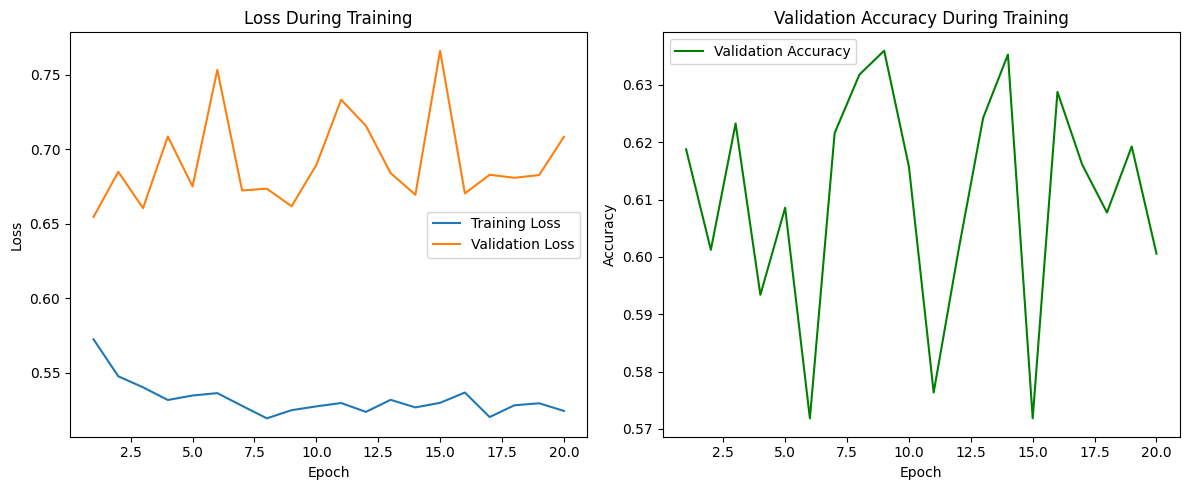

In [23]:
# train model
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=CONFIG['num_epochs'],
    scheduler=None,         # Optional: you can plug in a learning rate scheduler
    resume_from=None,       # Optional: provide path to checkpoint if resuming
    device=CONFIG['device'] # Uses GPU if available, otherwise CPU
)

**9. Model Evaluation**


=== Test Set Performance ===
Accuracy      : 0.5720
Precision     : 0.8839
Recall        : 0.5307
F1 Score      : 0.6632

Classification Report:
                 precision    recall  f1-score   support

         Benign       0.29      0.73      0.41      1567
High-grade CMIL       0.88      0.53      0.66      6039

       accuracy                           0.57      7606
      macro avg       0.59      0.63      0.54      7606
   weighted avg       0.76      0.57      0.61      7606



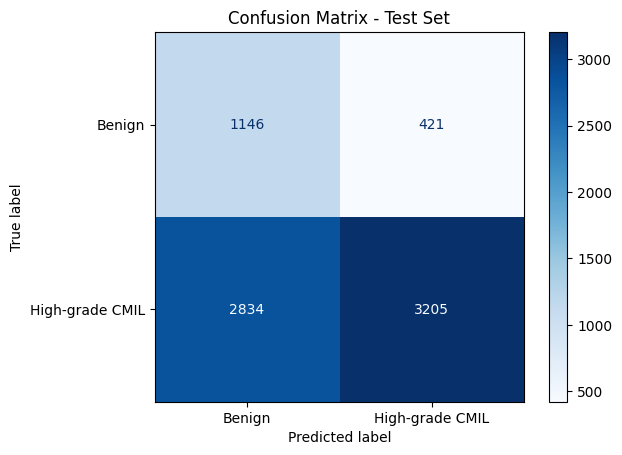

In [24]:
def evaluate_model_on_test(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in test_loader:  # `_` = case IDs (optional)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === Compute Metrics ===
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\n=== Test Set Performance ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Benign", "High-grade CMIL"]))

    # === Plot Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "High-grade CMIL"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Test Set")
    plt.show()

# === Run Evaluation ===
evaluate_model_on_test(trained_model, test_loader, CONFIG['device'])


**10. Patch Level to Case Level Prediction**

In [25]:
from torch.nn.functional import softmax
def evaluate_model_case_level_svc(model, df_train, df_test, train_loader, test_loader, k=25, tune_svc = False, return_pred = False):

    # === Collect model predictions for train and test datasets ===

    model.eval()
    all_probs_tr, all_probs_tst = [], []
    with torch.no_grad():
        for images, labels, _ in train_loader:
            images= (images.to(device))
            outputs = model(images)
            probs   = F.softmax(outputs, dim=1)
            all_probs_tr.extend(probs.cpu().numpy())

        for images, labels, _ in test_loader:
            images = (images.to(device))
            outputs = model(images)
            probs   = F.softmax(outputs, dim=1)
            all_probs_tst.extend(probs.cpu().numpy())
    train_prob = [arr[0] for arr in all_probs_tr]
    test_prob = [arr[0] for arr in all_probs_tst]

    # === Produce top k predicted probability dataframe for train data ===
    if df_train['stain'].nunique() > 1:
        all_top_k = []
        for stain in df_train['stain'].unique():
            df_train_rs = df_train.reset_index(drop=True)
            stain_df = df_train_rs[df_train_rs['stain']==stain]
            stain_prob = [train_prob[x] for x in stain_df.index]
            stain_top_k_prob = pd.DataFrame({'case_number': stain_df.case_number.values, 'prob': stain_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(25, columns='prob')).reset_index(drop=True)
            stain_top_k_prob['rank'] = top_k_prob.groupby('case_number').cumcount()
            stain_top_k_prob = top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()
            stain_top_k_prob.columns = [f'{stain}_prob_{col}' for col in stain_top_k_prob.columns]
            all_top_k.append(stain_top_k_prob)
        top_k_prob = pd.concat(all_top_k, axis=1).dropna(axis=0)
        case_label = df_train[df_train.case_number.isin(top_k_prob.index)].groupby('case_number')['label'].mean()
    else:
        df_train['label'] = df_train['case_number'].map(labels_map)
        top_k_prob = pd.DataFrame({'case_number': df_train.case_number.values, 'prob': train_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
        top_k_prob['rank'] = top_k_prob.groupby('case_number').cumcount()
        top_k_prob = top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()
        case_label = df_train[df_train.case_number.isin(top_k_prob.index)].groupby('case_number')['label'].mean()

    # === Make and fit SVC to train predicted probabilities ===
    if tune_svc:
        pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
        param_grid = [
            {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]},
            {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 0.01, 0.001, 0.0001]}
        ]
        svc = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
        svc.fit(top_k_prob, case_label)
        print('Selected parameters: ' + str(svc.best_params_))
    else:
        svc = make_pipeline(StandardScaler(), LinearSVC())
        svc.fit(top_k_prob, case_label)

    # === Produce top k predicted probability dataframe for test data ===
    if df_train['stain'].nunique() > 1:
        all_top_k = []
        for stain in df_train['stain'].unique():
            df_test_rs = df_test.reset_index(drop=True)
            stain_df = df_test_rs[df_test_rs['stain']==stain]
            stain_prob = [test_prob[x] for x in stain_df.index]
            stain_top_k_prob_tst = pd.DataFrame({'case_number': stain_df.case_number.values, 'prob': stain_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(25, columns='prob')).reset_index(drop=True)
            stain_top_k_prob_tst['rank'] = stain_top_k_prob_tst.groupby('case_number').cumcount()
            stain_top_k_prob_tst = stain_top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()
            stain_top_k_prob_tst.columns = [f'{stain}_prob_{col}' for col in top_k_prob_tst.columns]
            all_top_k.append(stain_top_k_prob_tst)
        top_k_prob_tst = pd.concat(all_top_k, axis=1).dropna(axis=0)
        case_label_tst = df_test[df_test.case_number.isin(top_k_prob_tst.index)].groupby('case_number')['label'].mean()
    else:
        df_test['label'] = df_test['case_number'].map(labels_map)
        top_k_prob_tst = pd.DataFrame({'case_number': df_test.case_number.values, 'prob': test_prob}).groupby('case_number', group_keys=False)[['case_number','prob']].apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
        top_k_prob_tst['rank'] = top_k_prob_tst.groupby('case_number').cumcount()
        top_k_prob_tst = top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()
        case_label_tst = df_test[df_test.case_number.isin(top_k_prob_tst.index)].groupby('case_number')['label'].mean()

    # === Calculate and print train metrics ===
    train_pred = svc.predict(top_k_prob)
    train_acc = accuracy_score(case_label, train_pred)
    train_rec = recall_score(case_label, train_pred)
    train_pre = precision_score(case_label, train_pred, zero_division=0)
    train_f1 = f1_score(case_label, train_pred, zero_division=0)
    print("\n=== Train Set Performance ===")
    print('Train Accuracy: ' + str(train_acc))
    print('Train Precision ' + str(train_pre))
    print('Train Recall: ' + str(train_rec))
    print('Train F1 Score: ' + str(train_f1))

    # === Calculate and print test metrics ===
    test_pred = svc.predict(top_k_prob_tst)
    test_acc = accuracy_score(case_label_tst, test_pred)
    test_rec = recall_score(case_label_tst, test_pred)
    test_pre = precision_score(case_label_tst, test_pred, zero_division=0)
    test_f1 = f1_score(case_label_tst, test_pred, zero_division=0)
    print("\n=== Test Set Performance ===")
    print('Test Accuracy: ' + str(test_acc))
    print('Test Precision ' + str(test_pre))
    print('Test Recall: ' + str(test_rec))
    print('Test F1 Score: ' + str(test_f1))
    print("\nClassification Report:")
    print(classification_report(case_label_tst, test_pred, target_names=["Benign", "High-grade CMIL"]))

    # === Produce and plot confusion matrix for test data ===
    cm = confusion_matrix(case_label_tst, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.xticks(ticks=[0,1], labels=['Benign', 'High-grade CMIL'])
    plt.yticks(ticks=[0,1], labels=['Benign', 'High-grade CMIL'])
    plt.xlabel('Predicted Case Grade')
    plt.ylabel('Actual Case Grade')
    plt.title("Confusion Matrix - Test Set Case Level")
    plt.show()

    if return_pred:
        return svc.predict(top_k_prob_tst)
    else:
        return None

In [26]:
from torch.nn.functional import softmax
import pandas as pd
import numpy as np # Make sure numpy is imported
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import Counter # Already imported at the top, but good to ensure

def evaluate_model_case_level_svc(model, df_train_meta_orig, df_test_meta_orig, train_loader, test_loader, k=25, tune_svc=False, return_pred=False, labels_map=None): # Added labels_map here
    device = CONFIG['device'] # Ensure device is accessible

    # === Collect model predictions and case_numbers for train and test datasets ===
    model.eval()

    # For training data
    all_probs_tr = []
    all_cids_tr = [] # Collect case IDs for matching later
    with torch.no_grad():
        for images, labels, cids in train_loader: # Collect cids from DataLoader
            if not (images.nelement() > 0):
                continue
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            all_probs_tr.extend(probs.cpu().numpy())
            all_cids_tr.extend(cids.cpu().numpy()) # Store cids

    # For testing data
    all_probs_tst = []
    all_cids_tst = [] # Collect case IDs for matching later
    with torch.no_grad():
        for images, labels, cids in test_loader: # Collect cids from DataLoader
            if not (images.nelement() > 0):
                continue
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            all_probs_tst.extend(probs.cpu().numpy())
            all_cids_tst.extend(cids.cpu().numpy()) # Store cids

    # Extract probabilities for class 0 (Benign) - assuming class 0 is "Benign" as per your report
    train_prob_class0 = [arr[0] for arr in all_probs_tr]
    test_prob_class0 = [arr[0] for arr in all_probs_tst]

    # === Prepare dataframes for top-k probabilities (Train) ===
    # Create a DataFrame of all processed patches with their case_numbers and probabilities
    processed_train_patches_df = pd.DataFrame({'case_number': all_cids_tr, 'prob': train_prob_class0})
    processed_train_patches_df['label'] = processed_train_patches_df['case_number'].map(labels_map) # Map labels here

    # Group by case_number and get top k probabilities
    top_k_prob_train = processed_train_patches_df.groupby('case_number', group_keys=False)[['case_number', 'prob']]\
                                                    .apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
    top_k_prob_train['rank'] = top_k_prob_train.groupby('case_number').cumcount()
    top_k_prob_train = top_k_prob_train.pivot(index='case_number', columns='rank', values='prob').dropna()

    # Get the corresponding case labels for the cases that have at least k patches
    case_label_train = processed_train_patches_df[processed_train_patches_df.case_number.isin(top_k_prob_train.index)]\
                                                    .groupby('case_number')['label'].first() # Use first as all labels for a case should be same

    # === Make and fit SVC to train predicted probabilities ===
    if tune_svc:
        pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
        param_grid = [
            {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]},
            {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 0.01, 0.001, 0.0001]}
        ]
        svc = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
        svc.fit(top_k_prob_train, case_label_train)
        print('Selected parameters: ' + str(svc.best_params_))
    else:
        svc = make_pipeline(StandardScaler(), LinearSVC())
        svc.fit(top_k_prob_train, case_label_train)

    # === Prepare dataframes for top-k probabilities (Test) ===
    # Create a DataFrame of all processed patches with their case_numbers and probabilities
    processed_test_patches_df = pd.DataFrame({'case_number': all_cids_tst, 'prob': test_prob_class0})
    processed_test_patches_df['label'] = processed_test_patches_df['case_number'].map(labels_map) # Map labels here

    # Group by case_number and get top k probabilities
    top_k_prob_test = processed_test_patches_df.groupby('case_number', group_keys=False)[['case_number', 'prob']]\
                                                .apply(lambda x: x.nlargest(k, columns='prob')).reset_index(drop=True)
    top_k_prob_test['rank'] = top_k_prob_test.groupby('case_number').cumcount()
    top_k_prob_test = top_k_prob_test.pivot(index='case_number', columns='rank', values='prob').dropna()

    # Get the corresponding case labels for the cases that have at least k patches
    case_label_test = processed_test_patches_df[processed_test_patches_df.case_number.isin(top_k_prob_test.index)]\
                                                .groupby('case_number')['label'].first() # Use first as all labels for a case should be same

    # === Calculate and print train metrics ===
    train_pred = svc.predict(top_k_prob_train)
    train_acc = accuracy_score(case_label_train, train_pred)
    train_rec = recall_score(case_label_train, train_pred, zero_division=0)
    train_pre = precision_score(case_label_train, train_pred, zero_division=0)
    train_f1 = f1_score(case_label_train, train_pred, zero_division=0)
    print("\n=== Train Set Performance (Case Level) ===")
    print(f'Train Accuracy: {train_acc:.4f}')
    print(f'Train Precision: {train_pre:.4f}')
    print(f'Train Recall: {train_rec:.4f}')
    print(f'Train F1 Score: {train_f1:.4f}')

    # === Calculate and print test metrics ===
    test_pred = svc.predict(top_k_prob_test)
    test_acc = accuracy_score(case_label_test, test_pred)
    test_rec = recall_score(case_label_test, test_pred, zero_division=0)
    test_pre = precision_score(case_label_test, test_pred, zero_division=0)
    test_f1 = f1_score(case_label_test, test_pred, zero_division=0)
    print("\n=== Test Set Performance (Case Level) ===")
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Test Precision: {test_pre:.4f}')
    print(f'Test Recall: {test_rec:.4f}')
    print(f'Test F1 Score: {test_f1:.4f}')
    print("\nClassification Report (Case Level):")
    print(classification_report(case_label_test, test_pred, target_names=["Benign", "High-grade CMIL"]))

    # === Produce and plot confusion matrix for test data ===
    cm = confusion_matrix(case_label_test, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "High-grade CMIL"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Test Set Case Level")
    plt.show()

    if return_pred:
        return test_pred
    else:
        return None

Selected parameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}

=== Train Set Performance (Case Level) ===
Train Accuracy: 0.8696
Train Precision: 0.9062
Train Recall: 0.9062
Train F1 Score: 0.9062

=== Test Set Performance (Case Level) ===
Test Accuracy: 0.4286
Test Precision: 0.5000
Test Recall: 0.3750
Test F1 Score: 0.4286

Classification Report (Case Level):
                 precision    recall  f1-score   support

         Benign       0.38      0.50      0.43         6
High-grade CMIL       0.50      0.38      0.43         8

       accuracy                           0.43        14
      macro avg       0.44      0.44      0.43        14
   weighted avg       0.45      0.43      0.43        14



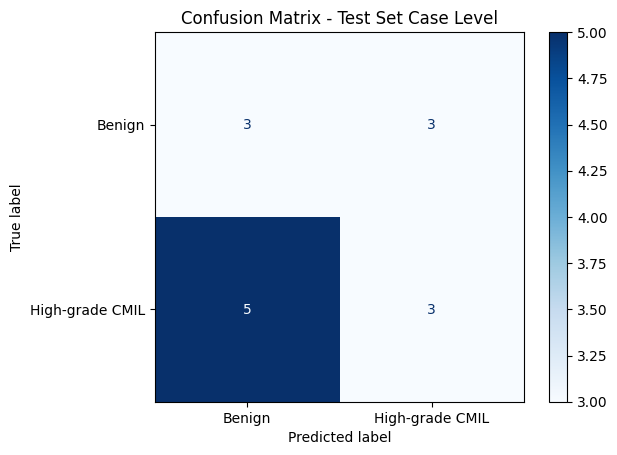

In [27]:
# === Run Case-Level Model Evaluation ===
evaluate_model_case_level_svc(model, train_meta, test_meta, train_loader, test_loader, 25, tune_svc=True, labels_map=labels_map)

**End of script – see below for other examples of correct model setups**

In [28]:
# # ─── 6) MODEL SETUP (KimiaNet) ───────────────────────────────────────────────

# # 1) Define your model object (KimiaNet with Adaptive Pooling)
# class KimiaNetClassifier(nn.Module):
#     def __init__(self, num_classes=2):
#         super(KimiaNetClassifier, self).__init__()
#         base = models.densenet121(weights=None)  # No ImageNet weights
#         self.features = base.features
#         self.classifier = nn.Linear(1024, num_classes)  # DenseNet121 output is 1024-d

#     def forward(self, x):
#         x = self.features(x)
#         x = nn.functional.relu(x, inplace=True)
#         x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
#         return self.classifier(x)

# model = KimiaNetClassifier(num_classes=2) # only doing binary classification right now

# # 2) Load pretrained KimiaNet weights and freeze backbone
# kimianet_path = '/content/drive/MyDrive/Junior Year/STAT 390/KimiaNetPyTorchWeights.pth'  # 🔁 Update to your local path
# state_dict = torch.load(kimianet_path, map_location='cpu')
# filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith("classifier")}
# model.load_state_dict(filtered_state_dict, strict=False)
# print("✅ Loaded KimiaNet backbone weights")

# for p in model.features.parameters():
#     p.requires_grad = False  # Freeze feature extractor

# # 3) (Already done above) Classifier head is defined as nn.Linear(1024, 2)

# # 4) Define optimizer on trainable parameters
# optimizer = optim.Adam(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr=CONFIG["lr"]
# )

# # 5) Optional class weights for imbalance
# def compute_class_weights(meta_df, labels_map):
#     lbls = [labels_map[int(cid)] for cid in meta_df.case_number if int(cid) in labels_map]
#     cnt = Counter(lbls)
#     total = sum(cnt.values())
#     return [total / cnt.get(0, 1), total / cnt.get(1, 1)]

# class_weights = compute_class_weights(train_meta, labels_map)
# cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(CONFIG["device"])
# criterion = nn.CrossEntropyLoss(weight=cw_tensor)

# # Move model to device
# model.to(CONFIG["device"])

In [29]:
# trained_model = train_model(
#     model=model,
#     optimizer=optimizer,
#     criterion=criterion,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     epochs=CONFIG['num_epochs'],s
#     scheduler=None,
#     resume_from=None,
#     device=CONFIG['device']
# )

In [30]:
# # ─── 7) MODEL SETUP (ResNET w/ CBAM) ───────────────────────────────────────────────

# # 0) Define CBAM Components. Please change ratio and kernel_size to tune

# class ChannelAttention(nn.Module):
#     def __init__(self, in_planes, ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)
#         self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
#         max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
#         return self.sigmoid(avg_out + max_out)

# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttention, self).__init__()
#         padding = 3 if kernel_size == 7 else 1
#         self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         x = torch.cat([avg_out, max_out], dim=1)
#         return self.sigmoid(self.conv1(x))

# class CBAM(nn.Module):
#     def __init__(self, channels):
#         super(CBAM, self).__init__()
#         self.ca = ChannelAttention(channels)
#         self.sa = SpatialAttention()

#     def forward(self, x):
#         x = self.ca(x) * x
#         x = self.sa(x) * x
#         return x

# class ResNetCBAM(nn.Module):
#     def __init__(self, num_classes=2):
#         super(ResNetCBAM, self).__init__()
#         base = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
#         self.features = nn.Sequential(
#             base.conv1,
#             base.bn1,
#             base.relu,
#             base.maxpool,
#             base.layer1,
#             CBAM(256),
#             base.layer2,
#             CBAM(512),
#             base.layer3,
#             CBAM(1024),
#             base.layer4,
#             CBAM(2048),
#             nn.AdaptiveAvgPool2d((6, 6))  # Match AlexNet-style output shape
#         )
#         in_ftrs = 2048 * 6 * 6
#         self.classifier = nn.Sequential(
#             nn.Dropout(), nn.Linear(in_ftrs, 4096), nn.ReLU(inplace=True),
#             nn.Dropout(), nn.Linear(4096, 4096), nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = torch.flatten(x, 1)
#         return self.classifier(x)


# # 1) Define your model object
# model = ResNetCBAM(num_classes=2)

# # 2) Freeze pretrained layers
# for p in model.parameters():
#     p.requires_grad = False

# # Optionally unfreeze the classifier
# for p in model.classifier.parameters():
#     p.requires_grad = True

# # 3)  Feature extractor already includes AdaptiveAvgPool2d and custom classifier should already be set

# # 4) Move model to device
# device = CONFIG["device"]
# model = model.to(device)

# # Optimizer over only trainable parameters
# optimizer = optim.Adam(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr=CONFIG["lr"]
# )

# # 5) Compute class weights for imbalance
# def compute_class_weights(meta_df, labels_map):
#     lbls = [labels_map[int(cid)] for cid in meta_df.case_number if int(cid) in labels_map]
#     cnt = Counter(lbls)
#     total = sum(cnt.values())
#     return [total / cnt.get(0, 1), total / cnt.get(1, 1)]

# class_weights = compute_class_weights(train_meta, labels_map)
# cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
# criterion = nn.CrossEntropyLoss(weight=cw_tensor)

In [ ]:
import os
os.kill(os.getpid(), 9)